In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fakescorr import fakescorr, find_nearest
%matplotlib inline
from matplotlib import rc, rcParams
rcParams.update({'font.size':12})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

def recovery(fakes, ID, save=False, figure=False):
    f = fakes.copy()
    f['ed_ratio']=f.ed_rec/f.ed_fake
    f = f.sort_values(by='ed_fake')[(f.ed_fake < 1e6) & (f.ed_ratio < 1.2)]
    
    lmax = np.log10(f.ed_fake.max())
    lmin = np.log10(f.ed_fake.min())
    bins = np.power(10,np.linspace(lmin,lmax,f.shape[0]/100))
    m = pd.DataFrame()
    f['range1'], bins = pd.cut(f.ed_fake, bins, retbins=True,include_lowest=True)
    m['mean_ed_fake'] = f.groupby('range1').ed_fake.mean()
    m['mean_rec_fake'] = f.groupby('range1').rec_fake.mean()
    m['std_rec_fake'] = f.groupby('range1').rec_fake.std()
    m = m.dropna(how='any')
    if figure == True:
        m.plot(x='mean_ed_fake', y='mean_rec_fake', yerr='std_rec_fake',loglog=True,
          label=('recovery rate'))
    threshold = m.mean_ed_fake[m.mean_rec_fake == find_nearest(m.mean_rec_fake.tolist(), 0.2)[0]].tolist()[0]
    return  threshold, m

def EDratio(fakes, ID, save=False, figure=False):
    f = fakes[fakes.rec_fake!=0.]
    f['ed_ratio']=f.ed_rec/f.ed_fake
    f = f.sort_values(by='ed_ratio')
    f = f[f.ed_ratio<1.5]
    if figure==True:
        plt.figure(figsize=(7,5))
        plt.scatter(f.ed_rec,f.ed_ratio,s=f.ed_rec_err/f.ed_rec*1e3, alpha=0.5,color='k',
                    label='$\sigma_{ED}/ED$')
        plt.axhline(y=1.,color='r')
        plt.axhline(y=1.1,color='r',linestyle='dashed')
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim((0.1,1.5))
        plt.xlim((1,1e6))
        plt.xlabel('recovered ED (s)')
        plt.ylabel('recovered ratio of injected ED')
        plt.title('EPIC {}'.format(ID))
        plt.legend(loc=4, frameon=False)
    if save == True:
        plt.savefig('stars_shortlist/share/corrected/ed_ratio_{}.png'.format(ID),
                    dpi=300)
    return 



In [2]:
def calc_thresh(ID,params,c):
    try:
        #path = 'stars_shortlist/{}/results/{}/fakes/{}_k2sc_allfakes.csv'.format(cluster,test,ID)

        path = '/home/eilin/research/k2_cluster_flares/aprun/k2sc_05/{}-c{}_kepler_v2_lc.fits_all_fakes.csv'.format(int(ID),c)
        
        df = pd.read_csv(path)
        threshold, m = recovery(df,ID)
        if 'thresh20p' not in params.columns:
            params['thresh20p'] = np.nan
        params['thresh20p'][params.EPIC==ID] = threshold
        
    except (FileNotFoundError, OSError):
        print('OF')
        pass
    return params

In [33]:
test = 'run_06'
Cs = ['Pleiades','M44']
Tlims = [(3000.0,3249.0,'red'),(3250.0,3499.0,'orange'),
         (3500.0,3749.0,'green'),(3750.0,4000.0,'c'),(3000.0,7000.0,'black'),
         (4000.0,7000.0,'blue')]
threshs = pd.DataFrame(Tlims,columns=['Tmin','Tmax','color'])
for cl in Cs:
    params = pd.read_csv('stars_shortlist/{0}/results/{1}/catalog/{0}_parameter_threshs.csv'.format(cl,test))
    if cl not in threshs.columns:
        threshs[cl]=np.nan
    for Tmin,Tmax,color in Tlims:
        Tb = params[(params['T'] <= Tmax) & (params['T'] >= Tmin)]

        Ethresh = Tb.thresh20p*Tb.L_quiet
        threshs[cl][(threshs.Tmin==Tmin) & (threshs.Tmax==Tmax)] = Ethresh.median()
#threshs.to_csv('stars_shortlist/share/{}_median_detection_thresholds.csv'.format(test))
threshs

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Tmin,Tmax,color,Pleiades,M44
0,3000.0,3249.0,red,4.781664e+32,1.131709e+33
1,3250.0,3499.0,orange,5.870064e+32,5.715820e+32
2,3500.0,3749.0,green,7.601244e+32,3.611787e+32
3,3750.0,4000.0,c,9.872670e+32,3.995716e+32
4,3000.0,7000.0,black,8.467838e+32,7.680612e+32
5,4000.0,7000.0,blue,2.213275e+33,1.325704e+33


In [34]:
threshs.to_csv('stars_shortlist/share/{}_median_detection_thresholds.csv'.format(test))

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


OF
OF
OF
OF
OF
OF
OF
OF
OF
OF
OF


,Unnamed: 0,EPIC,angDist,col1,Name,RAJ2000,DEJ2000,OName,Vmag,Ksmag,...,L_quiet_bol_err,todrop,whydrop,Date of Run,n_appa_flares,Filename,Total Exposure Time of LC in Days,BJD-2454833 days,Ethresh,thresh20p
0,0,210754915.0,0.826592,192.0,034428.08+191106.1,56.11701,19.18504,DH343,11.84,9.42,...,3.486613e+32,True,CMD,2018-08-20 13:11:27.959655,8.0,stars_shortlist/Pleiades/hlsp_k2sc_k2_llc_2107...,61.953611,2228.800105,4.608286e+33,75.040199
1,1,210762863.0,0.769552,166.0,034411.90+191819.4,56.04961,19.30539,DH318,15.10,11.05,...,3.141852e+31,True,CMD,2018-08-20 13:11:28.151584,4.0,stars_shortlist/Pleiades/hlsp_k2sc_k2_llc_2107...,61.690139,2228.800102,1.745902e+32,45.003241
2,2,210769047.0,0.728269,702.0,035623.92+192353.7,59.09967,19.39828,UGCSJ035623.92+192353.3,NaN,12.89,...,2.926220e+31,True,CMD,2018-08-20 13:11:28.338151,3.0,stars_shortlist/Pleiades/hlsp_k2sc_k2_llc_2107...,61.953611,2228.800291,2.819577e+32,287.202753
3,3,210770541.0,0.867280,811.0,035324.07+192516.8,58.35033,19.42136,s4543478,NaN,11.29,...,3.141852e+31,True,CMD,2018-08-20 13:11:28.488473,0.0,stars_shortlist/Pleiades/hlsp_k2sc_k2_llc_2107...,61.915972,2228.800250,2.329264e+32,60.040284
4,4,210776021.0,0.816603,683.0,035513.62+193016.9,58.80676,19.50472,DH813,16.74,11.72,...,3.141852e+31,True,CMD,2018-08-20 13:11:28.641807,4.0,stars_shortlist/Pleiades/hlsp_k2sc_k2_llc_2107...,60.749167,2228.800276,5.163437e+34,13309.535634
5,5,210779549.0,0.028077,219.0,034501.66+193333.7,56.25695,19.55937,PELS135,9.45,8.15,...,3.644548e+33,True,CMD,2018-08-20 13:11:28.775884,0.0,stars_shortlist/Pleiades/hlsp_k2sc_k2_llc_2107...,61.840694,2228.800118,5.895703e+33,8.291974
6,6,210784223.0,1.062146,684.0,035515.73+193746.6,58.81555,19.62963,s4745026,NaN,9.98,...,1.797245e+32,True,CMD,2018-08-20 13:11:28.929665,3.0,stars_shortlist/Pleiades/hlsp_k2sc_k2_llc_2107...,61.934792,2228.800278,3.340638e+33,131.975246
7,7,210784603.0,0.815150,759.0,033103.57+193805.1,52.76490,19.63475,s3289407,NaN,10.13,...,5.537500e+31,True,CMD,2018-08-20 13:11:29.113763,0.0,stars_shortlist/Pleiades/hlsp_k2sc_k2_llc_2107...,61.859514,2228.799917,1.360668e+32,26.205179
8,8,210791550.0,0.765664,726.0,035916.63+194427.5,59.81933,19.74099,UGCSJ035916.64+194427.1,NaN,12.69,...,2.926220e+31,True,CMD,2018-08-20 13:11:29.321264,7.0,stars_shortlist/Pleiades/hlsp_k2sc_k2_llc_2107...,61.915972,2228.800334,4.441926e+32,452.455570
9,9,210803812.0,0.817008,26.0,033910.20+195531.0,54.79251,19.92528,UGCSJ033910.21+195530.5,NaN,12.21,...,2.926220e+31,True,CMD,2018-08-20 13:11:29.473645,0.0,stars_shortlist/Pleiades/hlsp_k2sc_k2_llc_2108...,61.727778,2228.800037,1.583218e+32,161.266978


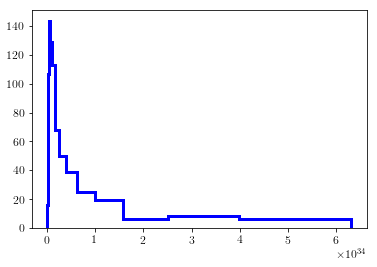

In [30]:
cluster = 'Pleiades'
test = 'run_06'
c = '04'
Tb = pd.read_csv('stars_shortlist/{0}/results/{1}/catalog/{0}_parameter.csv'.format(cluster,test))
Tb['Ethresh'] = np.nan

try:
    #print(Tb.columns.values)
    Tb['Ethresh'] = Tb['thresh20p']*Tb.L_quiet
except KeyError:
    for ID in Tb.EPIC.values:
        Tb = calc_thresh(ID,Tb,c)
        #print(Tb.columns.values)
    Tb['Ethresh'] = Tb['thresh20p']*Tb.L_quiet
if Tb.Ethresh.shape[0]!=0:
    Tb.Ethresh.hist(bins=np.power(10,np.arange(31,35,0.2)),histtype='step',
             color=color,linewidth=3,grid=False,label='{}-{}K'.format(Tmin,Tmax))

#print(Ethresh.median(),Ethresh.std())
    
Tb

In [32]:
Tb.to_csv('stars_shortlist/{0}/results/{1}/catalog/{0}_parameter_threshs.csv'.format(cluster,test))

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_

3.61178745738096e+32 1.608697872419885e+34


/usr/lib/python3.4/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3.61178745738096e+32 1.608697872419885e+34


,Unnamed: 0,EPIC,angDist,col1,Name,Mass,r'mag,Kmag,Prot1,Pw1,...,L_quiet_err,L_quiet_bol_err,todrop,whydrop,Date of Run,n_appa_flares,Filename,Total Exposure Time of LC in Days,BJD-2454833 days,Ethresh
0,0,211700306,0.741010,784,AD 2136,0.35,16.21,12.48,NaN,NaN,...,9.389271e+29,2.257583e+31,True,CMD,NaN,NaN,NaN,NaN,NaN,NaN
1,1,211707676,0.548785,760,AD 2848,0.16,20.17,14.31,0.31,0.0758,...,9.087047e+28,7.082975e+30,True,CMD,NaN,NaN,NaN,NaN,NaN,NaN
2,2,211708110,0.748653,779,AD 2192,0.18,18.99,13.88,NaN,NaN,...,1.938894e+29,6.959970e+30,True,CMD,NaN,NaN,NaN,NaN,NaN,NaN
3,3,211725787,0.500683,781,AD 1724,0.16,19.46,14.24,2.06,0.2196,...,9.087047e+28,7.082975e+30,True,CMD,NaN,NaN,NaN,NaN,NaN,NaN
4,4,211727975,0.579707,721,AD 2655,0.16,19.12,14.18,0.91,0.3663,...,2.477166e+29,2.240304e+31,True,CMD,NaN,NaN,NaN,NaN,NaN,NaN
5,5,211729756,0.501598,785,AD 1383,0.33,16.65,12.53,2.39,0.0612,...,9.389271e+29,2.257583e+31,True,CMD,NaN,NaN,NaN,NaN,NaN,NaN
6,6,211734093,0.541721,783,AD 2182,0.58,14.81,11.51,18.22,0.3548,...,1.687808e+30,5.537500e+31,True,CMD,NaN,NaN,NaN,NaN,NaN,2.317931e+32
7,7,211738707,0.546775,767,AD 3703,0.19,18.73,13.62,0.30,0.1439,...,2.477166e+29,2.240304e+31,True,CMD,NaN,NaN,NaN,NaN,NaN,NaN
8,8,211745306,0.519941,757,NaN,0.19,18.39,13.62,1.04,0.1684,...,4.149078e+29,2.926220e+31,True,CMD,NaN,NaN,NaN,NaN,NaN,NaN
9,9,211748286,0.739691,700,AD 1452,0.32,17.49,12.62,9.02,0.0514,...,4.149078e+29,2.926220e+31,True,CMD,NaN,NaN,NaN,NaN,NaN,NaN


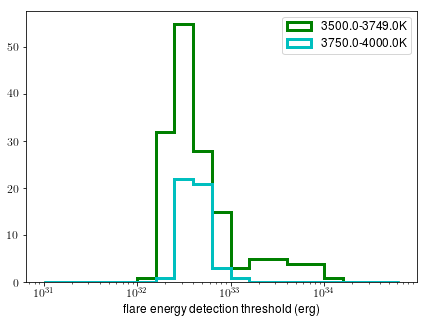

In [22]:
cluster = 'M44'
test = 'run_06'
c = '05'
params = pd.read_csv('stars_shortlist/{0}/results/{1}/catalog/{0}_parameter.csv'.format(cluster,test))
params['Ethresh'] = np.nan
plt.figure(figsize=(7,5))
for Tmin,Tmax,color in Tlims[2:4]:
    Tb = params[(params['T'] <= Tmax) & (params['T'] >= Tmin)]
    try:
        #print(Tb.columns.values)
        Tb['Ethresh'] = Tb['thresh20p']*Tb.L_quiet
    except KeyError:
        for ID in Tb.EPIC.values:
            Tb = calc_thresh(ID,Tb,c)
            #print(Tb.columns.values)
        Tb['Ethresh'] = Tb['thresh20p']*Tb.L_quiet
    if Tb.Ethresh.shape[0]!=0:
        Tb.Ethresh.hist(bins=np.power(10,np.arange(31,35,0.2)),histtype='step',
                 color=color,linewidth=3,grid=False,label='{}-{}K'.format(Tmin,Tmax))
    plt.xscale('log')
    plt.xlabel('flare energy detection threshold (erg)')
    plt.legend()
    plt.savefig('stars_shortlist/share/{}_{}_median_detection_thresholds.png'.format(test,cluster))
    print(Ethresh.median(),Ethresh.std())
    
    params.Ethresh[params.EPIC.isin(Tb.EPIC.values)] = Tb.Ethresh
params